# COMP47750 Assignment 2
## Name: John O'Grady
## Student number: 16405752

### Objective:
The objective of this assignment is to assess the impact of feature engineering on a traffic volume prediction task. The data is available in the file metro_traffic_15_19.csv. This file is an extract from the UCI dataset here https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume. Information about each of the columns can be found by clicking on the link

The idea is to generate effective features for predicting traffic volume from data available a day in advance. 


### Importing libraries and assessing data

In [1]:
import pandas as pd # for handling data frames
import numpy as np # for formating arrays
from sklearn import preprocessing # sklearn function for data normalisation - StandardScalar
from sklearn.model_selection import train_test_split # Function splitting data into test and train for model evaluation
from sklearn.preprocessing import StandardScaler # Scaler for normalization
from sklearn.linear_model import LinearRegression, SGDRegressor # Reg
from matplotlib import pyplot as plt # for plotting
import matplotlib.dates as mdates # for dates in matplotlib plots
from sklearn.metrics import mean_absolute_percentage_error as MAPE # evaluation metric
from sklearn.metrics import mean_absolute_error, r2_score # evaluation metric for regression
import datetime # Converting time series data to format known by pandas
from sklearn.ensemble import RandomForestRegressor # Non linear regressor
from sklearn.inspection import permutation_importance # Assessing permutation importance in Random Forest regressor
from mlxtend.feature_selection import SequentialFeatureSelector as SFS # Sequential Feature Selector # mlxtend
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs # Plotting forward/backward sequential search outputs

In [2]:
# Load in the raw data and have a look at it
traffic_volume_raw = pd.read_csv("metro_traffic_15_19.csv")

# Dimensions of the data
print(f'Dimensions of dataset: {traffic_volume_raw.shape}')
print()

# Information about each particular column
print(f'{traffic_volume_raw.info()}')

Dimensions of dataset: (32047, 6)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32047 entries, 0 to 32046
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date_time       32047 non-null  object 
 1   rain_1h         32047 non-null  float64
 2   snow_1h         32047 non-null  float64
 3   temp            32047 non-null  float64
 4   clouds_all      32047 non-null  int64  
 5   traffic_volume  32047 non-null  int64  
dtypes: float64(3), int64(2), object(1)
memory usage: 1.5+ MB
None


- Can see that there are 5 features, date_time, rain_1h, snow_1h, temp, clouds_all which help explain traffic volumne. These features are represented by 32047 example data points. We need to engineer these features, particulary the date_time feature to predict traffic volumne a day in advance.

***
## Task 1
***

### 1. Load the dataset into a dataframe that can be used for predicting  traffic_volume a day in advance.

#### Checking for missing data
- If missing data is present, it may need to be imputed. As is seen below, there is no missing data

In [3]:
# Check to see if there are any missing values as these will need to be imputed if so
num_vars = traffic_volume_raw.columns[traffic_volume_raw.dtypes != "object"] # subset columns that are not date_time
traffic_volume_raw[num_vars].isnull().sum().sort_values(ascending=False) # sort by order

rain_1h           0
snow_1h           0
temp              0
clouds_all        0
traffic_volume    0
dtype: int64

#### Identification of duplicate rows
- There are duplicate rows [e.g., row 84 and 85 (not shown)], this can be a problem as the same information can be present in the training and testing dataset, even when setting the `shuffle` paramater to _false_ __potentially confounding accuracy measurements in the testing set__, and also potentially inadvertently interfering with the cyclical encoding procedure (discussed below), it is important to remove these before evaluating a model and engineering features

In [4]:
print("Total number of duplicated rows")
print(f"{traffic_volume_raw.duplicated(subset=['date_time', 'rain_1h', 'snow_1h','temp','clouds_all','traffic_volume']).sum()}")
print("Number of non duplicated rows")
print(f'{(~traffic_volume_raw.duplicated()).sum()}')
# Keeping the non duplicated rows
traffic_volume_raw.drop_duplicates(inplace=True) #drop duplicates but keep original data frame
traffic_volume_raw = traffic_volume_raw.reset_index(drop = True) # reset the index

Total number of duplicated rows
5464
Number of non duplicated rows
26583


#### Getting date_time feature into a date time object
- In order to be able to manipulate time series data, it is necessary to convert the date_time feature to a date_time object so that other features required such as hour, day week etc can be extracted.

In [5]:
# We need to convert date_time feature into DateTime Object so that we can use different methods on it.
# For that, will use the to_datetime method from the pandas library
# Will also be useful for plotting below
traffic_volume_raw["date_time"] = pd.to_datetime(traffic_volume_raw["date_time"])
traffic_volume_raw["time_series"] = traffic_volume_raw["date_time"]

# Need to duplicate as we will join by index below with lag features
traffic_volume_raw["time_series"] = pd.to_datetime(traffic_volume_raw["time_series"])
traffic_volume_raw = traffic_volume_raw.set_index("time_series")
traffic_volume_raw.head(2)

,date_time,rain_1h,snow_1h,temp,clouds_all,traffic_volume
time_series,,,,,,
2015-07-01 00:00:00,2015-07-01 00:00:00,0.0,0.0,289.2,1,737
2015-07-01 01:00:00,2015-07-01 01:00:00,0.0,0.0,289.4,1,444


#### Building lags and adding features
We can add previous time stamps which may help to predict traffic a day in advance from the current time-stamp. These features are known as lags and can be a powerful addition to a predictive model.
Adding these lags will increase the dimensionality of the data and increase the number of features per example.

In [6]:
# Need to build out an X matrix with lags
y = traffic_volume_raw["traffic_volume"]
day_1 = traffic_volume_raw.iloc[0:23,] # save day 1 - can be used as a validation set
traffic_volume_raw = traffic_volume_raw.iloc[23:,] # skip first 24 hours
window = 23
y_loop = np.array(y)
X = []
for idx in range(len(y) - window):
    X.append(y_loop[idx:idx + window])
X = pd.DataFrame(X)

# Set the column names - each number represent hour before the target column
X.columns =['t-23','t-22','t-21','t-20','t-19','t-18','t-17','t-16','t-15','t-14',
            't-13','t-12','t-11','t-10','t-9','t-8','t-7','t-6','t-5','t-4','t-3',
            't-2','t-1']

# Set the index of this matrix to the same as traffic_volume
# Rename the index
X = X.set_index(traffic_volume_raw["date_time"]) # set the index for merging
X.index.name = "time_series"
# Merge together
traffic_volume_raw = pd.concat([traffic_volume_raw, X], axis =1)
traffic_volume_raw.head(3)

,date_time,rain_1h,snow_1h,temp,clouds_all,traffic_volume,t-23,t-22,t-21,t-20,...,t-10,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1
time_series,,,,,,,,,,,,,,,,,,,,,
2015-07-02 00:00:00,2015-07-02 00:00:00,0.0,0.0,287.36,1,1265,737,444,347,356,...,4996,5623,6210,5969,4604,3649,3144,2788,2356,2820
2015-07-02 01:00:00,2015-07-02 01:00:00,0.0,0.0,286.47,1,566,444,347,356,936,...,5623,6210,5969,4604,3649,3144,2788,2356,2820,1265
2015-07-02 02:00:00,2015-07-02 02:00:00,0.0,0.0,286.22,1,373,347,356,936,2886,...,6210,5969,4604,3649,3144,2788,2356,2820,1265,566


#### Adding the +24 timestamp after the current time stamp - This will be our target variable
- We need to engineer time stamps a day in advance (24 steps) of the current time stamp, stored in the feature _traffic_volume_. To do this we will use the `.shift()` method.

In [7]:
# Generate a new column with that step of traffic volume + i hours after the current time stamp.
traffic_volume_raw['t+24'] = traffic_volume_raw["traffic_volume"].shift(-24)
    

# Extract the final day as we are unable to forecast values for this which we do not have
# Drop the final day from the overall matrix
final_day = traffic_volume_raw.loc["2018-09-30 00:00:00":"2018-09-30 23:00:00"]
final_day = final_day.dropna(axis = 1)

traffic_volume_raw = traffic_volume_raw.dropna(axis = 0) # drop rows with NAN - These are the bottom rows
traffic_volume_raw[["traffic_volume","t+24"]].head(25)

,traffic_volume,t+24
time_series,,
2015-07-02 00:00:00,1265,959.0
2015-07-02 01:00:00,566,615.0
2015-07-02 02:00:00,373,456.0
2015-07-02 03:00:00,356,359.0
2015-07-02 04:00:00,801,464.0
2015-07-02 05:00:00,2696,961.0
2015-07-02 06:00:00,5400,1939.0
2015-07-02 07:00:00,5933,2368.0
2015-07-02 08:00:00,4987,2523.0


- Can see that the __target variable (24h in advance)__ is correct

### 2.	Produce some plots at different time-scales to see if there is periodicity in the traffic volume. 
#### Periodicity over time

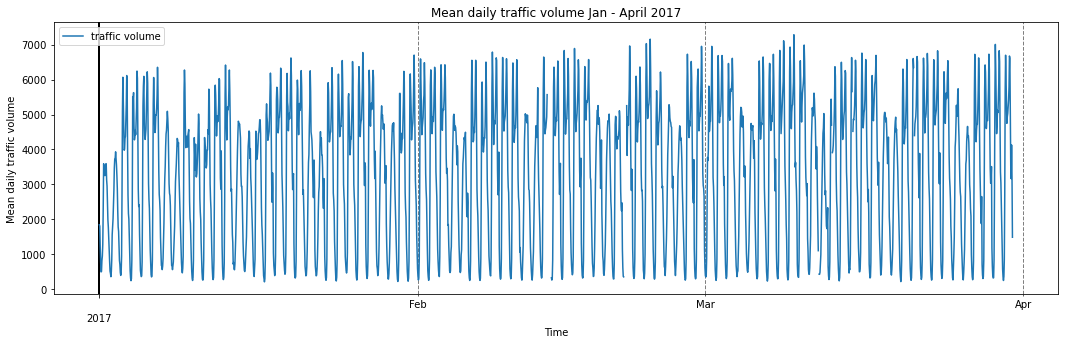

In [8]:
# Subset 3 months otherwise it looks too messy
# To plot
month = traffic_volume_raw.loc["2017-01-01 00:00:00": "2017-03-30 23:00:00"] # generate the slice
month = month[["date_time","traffic_volume"]] # subset relevant columns
# Group by day to show monthly traffic volume
month = month.groupby(pd.Grouper(key='date_time', freq="1H")).mean() # group by day
fig, ax1 = plt.subplots(nrows=1, ncols=1,figsize=(18, 5)) # plot figure
ax1.plot(month["traffic_volume"])  
ax1.set_title('Mean daily traffic volume Jan - April 2017')
ax1.set_xlabel("Time")
ax1.set_ylabel('Mean daily traffic volume')
# Format labels
ax1.xaxis.set(
    major_locator=mdates.YearLocator(), # major ticks will be year
    major_formatter=mdates.DateFormatter("\n%Y"), # format we want
    minor_locator=mdates.MonthLocator((1,2,3,4,5,6,7,8,9,10,11,12)), # minor ticks will be months in the year
    minor_formatter=mdates.DateFormatter("%b")) # format in short hand
ax1.grid(which="major", linewidth=2, color = "black", axis = "x") # linetypes of major ticks
ax1.grid(which="minor", linewidth=1, color = "grey", linestyle = "--", axis = "x")
ax1.legend(["traffic volume"])
None

- Doesn't  really appear to be a cyclical pattern to traffic at a month level. There is variability between months but no cyclical signal can really be established. For example, at the begeinning of a particular month if mean daily traffic volume is low, that may not be the case for another month (e.g., Month Feb and March). Intra-month variability in traffic may be due to the weekend effect which we will assess now.

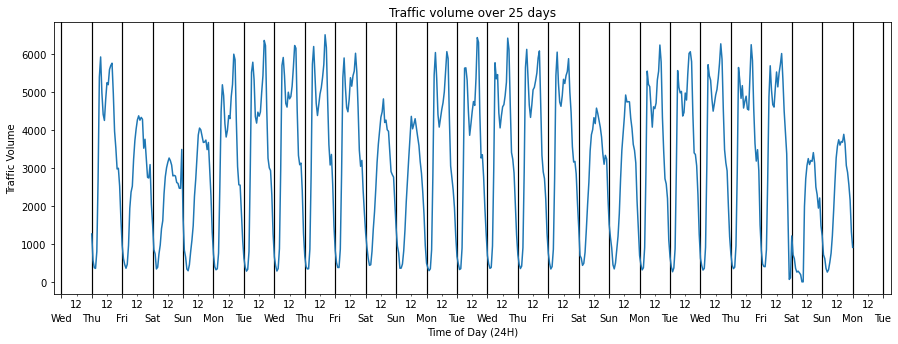

In [9]:
## DAILY
traffic_day_slice = traffic_volume_raw.iloc[0:600, np.r_[0, 5]] # 25 days for plotting
# plotting over many days
fig, ax1 = plt.subplots(figsize=(15, 5))
ax1.set(xlabel='Time of Day (24H)', ylabel='Traffic Volume')
ax1.plot(traffic_day_slice["date_time"], traffic_day_slice["traffic_volume"])
ax1.xaxis.set(
    major_locator=mdates.DayLocator(),
    major_formatter=mdates.DateFormatter("\n%a"),
    minor_locator=mdates.HourLocator((0, 12, 24)),
    minor_formatter=mdates.DateFormatter("%H"))
ax1.set_title('Traffic volume over 25 days')
ax1.grid(which="major", linewidth=1.2, color = "black", axis = "x")
plt.show()

- Definitely a cyclical nature at a daily level. Traffic generally higher during the weekdays with two peak in the middle of the day and lowest towards the beginning and end of the day. Traffic is generally lower at the weekend but follows a pattern similar, but not equal to the weekday

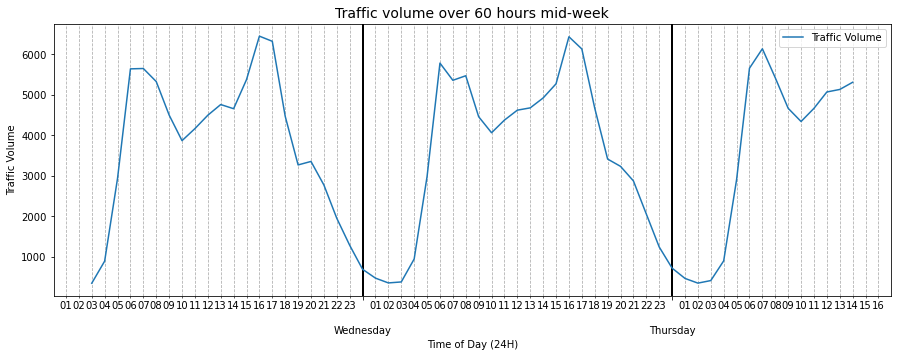

In [10]:
# HOURLY
traffic_hour_slice = traffic_volume_raw.iloc[290:350,np.r_[0, 5]] # 2.5 days (60hrs) for plotting
fig, ax1 = plt.subplots(figsize=(15, 5))
ax1.set(xlabel='Time of Day (24H)', ylabel='Traffic Volume')
ax1.plot(traffic_hour_slice["date_time"], traffic_hour_slice["traffic_volume"])
ax1.xaxis.set(
    major_locator=mdates.DayLocator(),
    major_formatter=mdates.DateFormatter("\n\n%A"),
    minor_locator=mdates.HourLocator((1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24)),
    minor_formatter=mdates.DateFormatter("%H"))
ax1.set_title('Traffic volume over 60 hours mid-week', 
             fontsize = 14)
ax1.grid(which="major", linewidth=2, color = "black", axis = "x")
ax1.grid(which = "minor", linestyle = "--",)
ax1.legend(["Traffic Volume"])
plt.show()

- Definitely a cyclical pattern at an hourly scale. In this zoomed up figure, can see that traffic volume is low in the mornings and in the late evenings. peaks around 7am and 4 PM before falling again into the early hours of the next day

#### Summary of plots


- The above plots show that there is periodicity in the traffic volume at a daily and hourly scale and less so at a month level
- In the first plot, showing the mean __weekly traffic volume over time__. While there __doesn't appear to be periodicitiy in the data at a month level__ there are some trends which may be important.
- In the second plot, showing __traffic volume accross 25 days__. One can see that traffic volume is higher during the week days as opposed to the weekend. During the weekday, there appears to be 2 peaks in traffic (approx 8-9AM and 4-6 PM) with traffic volumes relativley low before and after these rush hour periods respectively. Between these periods, traffic volume tends to reduce a small amount. During the weekend, traffic volume follows a similar pattern, being very low in the morning and rising steadily and reaching a peak around 4PM before falling again to low levels as night time approaches. Although the traffic volume during the weekend is gernerally lower
- In the third plot, showing how __traffic volume varies by hour__ during 2.5 week days, one can see that traffic volume begins to rise after 3AM to the first peak around 7AM, decreases and plateaus at around 9AM until 1 PM and rises to the second peak around 4PM before decreasing there after.
- __There is periodicity in the data__ *_for traffic volume over time_* and any model must be informed of this before any accurate predictions can be made

#### Viewing other variables over time

- It can be useful to see patterns of other variables in the data as one can indirectly form an idea about that variable's importance in predicting traffic volume. For example, if snow_1h is highly variable and correlated with traffic volume, then snow_1h is an important variable. However if snow_1h only appears over the course of 1 week, then in the overall context of traffic_volume, that varaible may not be that important in predicting traffic volume.
- One should always try to visualise the data to grasp what is at the kernel of the dataset

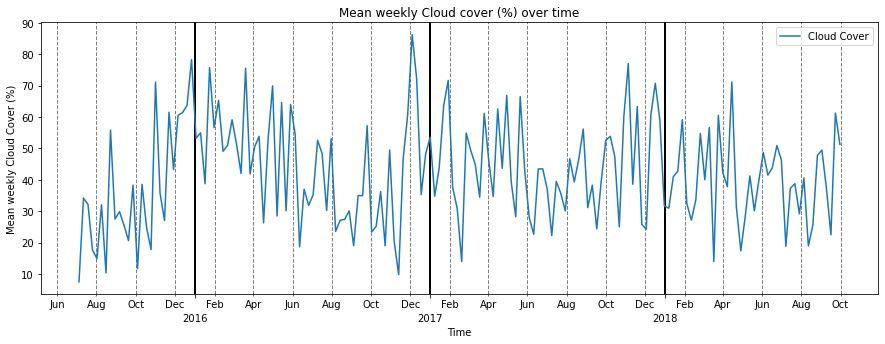

In [11]:
# WEEKLY MONTHLY and YEARLY data for cloud cover
traffic_volume_plot = traffic_volume_raw.groupby(pd.Grouper(key='date_time', freq="1W")).mean() # group by week
traffic_volume_plot = traffic_volume_plot[["clouds_all"]] # subset data frame
fig, ax1 = plt.subplots(nrows=1, ncols=1,figsize=(15, 5)) # plot figure
ax1.plot(traffic_volume_plot["clouds_all"]) 
ax1.set_title('Mean weekly Cloud cover (%) over time')
ax1.set_xlabel("Time")
ax1.set_ylabel('Mean weekly Cloud Cover (%)')
ax1.xaxis.set(
    major_locator=mdates.YearLocator(), # major ticks will be year
    major_formatter=mdates.DateFormatter("\n%Y"), # format we want
    minor_locator=mdates.MonthLocator((2,4,6,8,10,12)), # minor ticks will be months in the year
    minor_formatter=mdates.DateFormatter("%b")) # format in short hand
ax1.grid(which="major", linewidth=2, color = "black", axis = "x") # linetypes of major ticks
ax1.grid(which="minor", linewidth=1, color = "grey", linestyle = "--", axis = "x")
ax1.legend(["Cloud Cover"])
None

- Doesnt appear to be any real pattern associated with cloud cover, hugely variable

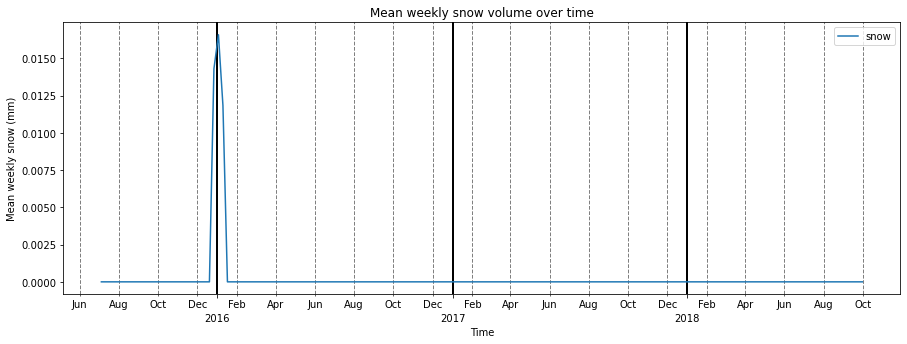

In [12]:
# SNOW
traffic_volume_plot = traffic_volume_raw.groupby(pd.Grouper(key='date_time', freq="1W")).mean() # group by week
traffic_volume_plot = traffic_volume_plot[["snow_1h"]] # subset data frame
fig, ax1 = plt.subplots(nrows=1, ncols=1,figsize=(15, 5)) # plot figure
ax1.plot(traffic_volume_plot["snow_1h"]) 
ax1.set_title('Mean weekly snow volume over time')
ax1.set_xlabel("Time")
ax1.set_ylabel('Mean weekly snow (mm)')
ax1.xaxis.set(
    major_locator=mdates.YearLocator(), # major ticks will be year
    major_formatter=mdates.DateFormatter("\n%Y"), # format we want
    minor_locator=mdates.MonthLocator((2,4,6,8,10,12)), # minor ticks will be months in the year
    minor_formatter=mdates.DateFormatter("%b")) # format in short hand
ax1.grid(which="major", linewidth=2, color = "black", axis = "x") # linetypes of major ticks
ax1.grid(which="minor", linewidth=1, color = "grey", linestyle = "--", axis = "x")
ax1.legend(["snow"])
None

- Snow only becomes a relevant feature at the weekly scale in December when there was a spike in snow during the final few weeks of 2016 / early 2017.
- May not be contributing that much to any predictive model

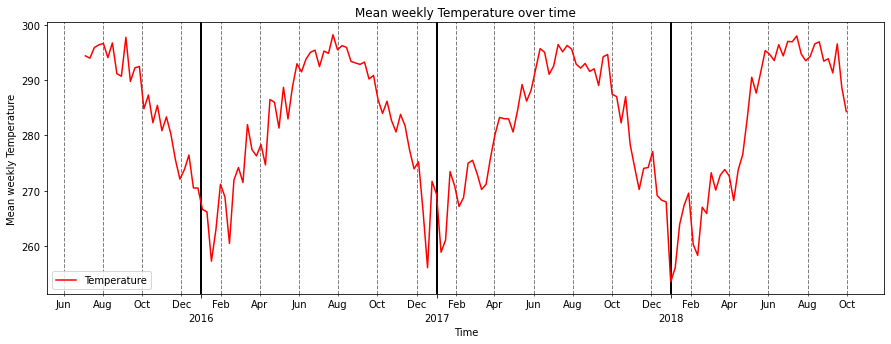

In [13]:
# Temperature
# Group by week
traffic_volume_plot = traffic_volume_raw.groupby(pd.Grouper(key='date_time', freq="1W")).mean() # group by week
traffic_volume_plot = traffic_volume_plot[["temp"]] # subset data frame
fig, ax1 = plt.subplots(nrows=1, ncols=1,figsize=(15, 5)) # plot figure
ax1.plot(traffic_volume_plot["temp"], color = "red") 
ax1.set_title('Mean weekly Temperature over time')
ax1.set_xlabel("Time")
ax1.set_ylabel('Mean weekly Temperature')
ax1.xaxis.set(
    major_locator=mdates.YearLocator(), # major ticks will be year
    major_formatter=mdates.DateFormatter("\n%Y"), # format we want
    minor_locator=mdates.MonthLocator((2,4,6,8,10,12)), # minor ticks will be months in the year
    minor_formatter=mdates.DateFormatter("%b")) # format in short hand
ax1.grid(which="major", linewidth=2, color = "black", axis = "x") # linetypes of major ticks
ax1.grid(which="minor", linewidth=1, color = "grey", linestyle = "--", axis = "x")
ax1.legend(["Temperature"])
None

- Seasonal pattern to temperature which is to be expected

***
## Task 2
***

### 1.	Extract hour, day and month features from the time-stamps

In [14]:
# Now we have the DateTime object generated, can extract information form it with the .dt method

# Year - useful for looking to see if ther are differences between years by plotting
traffic_volume_raw['year'] = traffic_volume_raw['date_time'].dt.year
# Month
traffic_volume_raw['month'] = traffic_volume_raw['date_time'].dt.month
#day of month, may not be useful
traffic_volume_raw['day'] = traffic_volume_raw['date_time'].dt.day 
# day of week important variable (e.g. school day) - - #Monday is 0 and Sunday is 6
traffic_volume_raw['day_of_week'] = traffic_volume_raw['date_time'].dt.weekday 
# Hour
traffic_volume_raw['hour'] = traffic_volume_raw['date_time'].dt.hour # required

# reorder
traffic_volume_raw = traffic_volume_raw[['year', 'month', 'day', 'day_of_week', 'hour', 
                                         'rain_1h', 'snow_1h', 'temp', 'clouds_all', 't-23','t-22','t-21','t-20',
                                         't-19','t-18','t-17','t-16','t-15','t-14','t-13','t-12','t-11','t-10','t-9',
                                         't-8','t-7','t-6','t-5','t-4','t-3', 't-2','t-1', 
                                         'traffic_volume', 't+24']]

# Extract relevant features
# Will keep raw dataset for plotting and as reference
# Year not needed and also a categorical varibale that cannot be cyclically encoded
traffic_volume_simple = traffic_volume_raw[['month', 'day', 'day_of_week', 'hour', 
                                         'rain_1h', 'snow_1h', 'temp', 'clouds_all', 't-23','t-22','t-21','t-20',
                                         't-19','t-18','t-17','t-16','t-15','t-14','t-13','t-12','t-11','t-10','t-9',
                                         't-8','t-7','t-6','t-5','t-4','t-3', 't-2','t-1', 
                                         'traffic_volume','t+24']]

#### Average values accross different time scales
- Now that we have established periodicity in the data (both within and accross weeks and days and hours), it will be useful to conclude by looking at mean values accross the entire dataset for each time stamp value we have

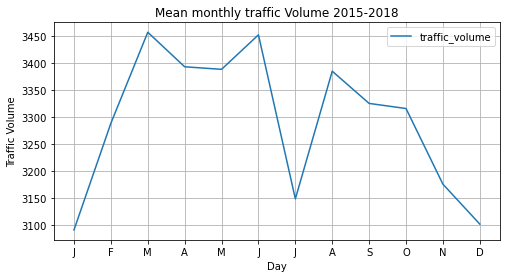

In [15]:
# Looking at mean monthly traffic volume values
monthly = traffic_volume_raw[['month','traffic_volume']] # subset
monthly = monthly.sort_values('month')
monthly = monthly.groupby('month')['traffic_volume'].mean()
f, ax = plt.subplots(figsize=(8,4))
monthly.plot(ax=ax,rot=0)
ax.set_title('Mean monthly traffic Volume 2015-2018')
ax.set_ylabel("Traffic Volume")
ax.set_xlabel('Day')
ax.set_xticks(range(1, 13))
ax.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
ax.legend()
ax.grid()

- Some months are missing for the years 2015 and 2018 (data not recorded), hence, it would be appropraite to view the mean traffic volume for each year separetly to get a better picture

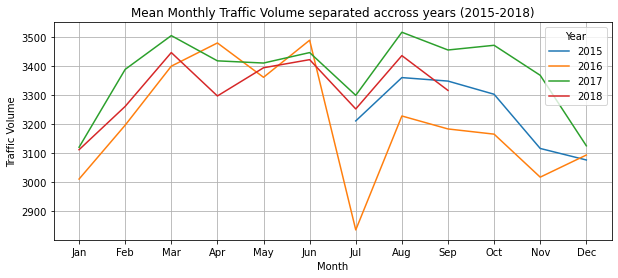

In [16]:
# Re define variable
monthly = (traffic_volume_raw.groupby([traffic_volume_raw['year'], traffic_volume_raw['month']]) # group by  both
           .mean() # get the mean
           .rename_axis(index=['year', 'month'],) # redefine the index as both
           .reset_index()) # reset the index         
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4))
years = list(traffic_volume_raw['year'].unique())
# plot each year in a loop
for year in years:
    # plotting for one year
    sub = monthly[monthly['year'] == year]
    ax.plot(sub['month'], sub['traffic_volume'], linestyle='-', label=year)
    # some formatting
    ax.set_title('Mean Monthly Traffic Volume separated accross years (2015-2018)')
    ax.set_ylabel("Traffic Volume")
    ax.set_xlabel('Month')
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
    ax.legend(title = "Year")
ax.grid()

- Can see here that 2016 is having a big effect on the mean traffic value for the month of July accross the entire dataset. Overall, it appears that traffic volume was lower in the second half of 2016 versus other years. However, there is variability within months accross years e.g., average traffic volume accross 2017 was higher for 11 months compared to 2018 suggesting that year may be an important feature in this data set. 

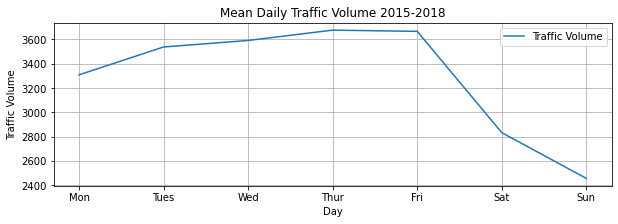

In [17]:
# Mean daily
daily = traffic_volume_raw[['day_of_week','traffic_volume']] # subset
daily = daily.sort_values('day_of_week') # ensure monday is first
daily = daily.groupby('day_of_week')['traffic_volume'].mean()
f, ax = plt.subplots(figsize=(10,3))
daily.plot(ax=ax,rot=0)
ax.set_title('Mean Daily Traffic Volume 2015-2018')
ax.set_ylabel("Traffic Volume")
ax.set_xlabel('Day')
ax.set_xticks(range(0, 7))
ax.set_xticklabels(['Mon','Tues','Wed','Thur','Fri','Sat','Sun'])
ax.legend(labels = ["Traffic Volume"])
ax.grid()

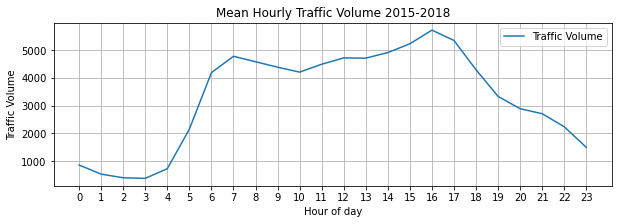

In [18]:
# hourly
hourly = traffic_volume_raw[['hour','traffic_volume']] # subset
hourly = hourly.sort_values('hour')
hourly = hourly.groupby('hour')['traffic_volume'].mean()
f, ax = plt.subplots(figsize=(10,3))
hourly.plot(ax=ax,rot=0)
ax.set_title('Mean Hourly Traffic Volume 2015-2018')
ax.set_ylabel("Traffic Volume")
ax.set_xlabel('Hour of day')
ax.set_xticks(range(0, 24))
ax.legend(labels = ["Traffic Volume"])
ax.grid()

- The above two plots essentially replicate the patterns in the periodicity plots discussed previously. The daily plot highlights that, on average, traffic volume is higher during the weekdays in comparison to the weekends. THe hourly plot shows that traffic volume is lower during the late/early hours of the night/morning respectively and reaches a high around rush hour (7AM and 4PM).

### 2.	Divide the data into train and test sets keeping one third of the data for testing. 

In [19]:
# Copy the data
# May require for later
traffic_volume_raw_2 = traffic_volume_raw.copy()

# Define the target columns
Y = traffic_volume_raw.pop("t+24").values
X = traffic_volume_raw.values


X_tr, X_ts, Y_tr, Y_ts = train_test_split(X, Y, test_size=1/3, shuffle=False) # shuffle = false as it is time series data

####  Normalization 
- Normalization is important in the context of regression as once variables are normalized, the respective coefficients (__Betas__) which are outputted in the regression model are __directly comparable__. One can say that one variable is having a positive and another variable is having a negative effect respectively on the independent variable of interest, in this case, traffic volume
- Understanding model coefficients is important in the context understanding the effects of each independent variable on the dependent variable, and to make inferences about each variable's importance in a model

In [20]:
# standard scaler from scikit learn
scaler = StandardScaler() # initialise a standard scaler
X_tr_scaled = scaler.fit_transform(X_tr) # fit and transform the training data 
X_ts_scaled = scaler.transform(X_ts) # transform the test data set

- Here, we have split up the dataset into test train split, keeping the 1/3 of the data for testing. We have normalised the data using a `StandardScaler` from sklearn, fitting it to the training set and transforming both the training and testing dataset respectively.

### 3.	Build two different regression models and test the accuracy. Try Linear Regression and one other regression model from scikit learn. 

#### Linear Regression
- Linear regression __assumes that a linear relationship exists__ between the *dependent variable (Y)* and the *independent variable(s) (X1, X2, ....Xn)*. Linear Regression is also a useful predictive model for a numeric, continuous independent variable as opposed to logistic regression which is useful for a categorical dependent variable.
- The `LinearRegression` function from scikit lean tries to model the beta coefficients such that the __residual sum of squares__ (unexplained variation) between the observed targets and the predicted targets is minimised.
- Specifically, this type of modelling is also known as __Ordinary Least Squares Regression__
- Here, as we are considering more than one variable, we will be conducting __Multiple Linear Regression__

In [21]:
# Set up linear regression object with default paramaters
linear = LinearRegression()

# Fit it to the training data
linear.fit(X_tr_scaled, Y_tr)

# Predict
y_predict_train = linear.predict(X_tr_scaled) # not really appropriate but useful to assess overfitting
y_predict = linear.predict(X_ts_scaled)

# View a range of evaluation metric (Explanation below)
print("TRAINING SET METRICS - Linear Regression")
print('Traffic Volume Test - R-squared: {:.5f}'.format(linear.score(X_tr_scaled, Y_tr)))
print('Traffic Volume Test - MAE: {:.3f}'.format(mean_absolute_error(Y_tr, y_predict_train)))
print('Traffic Volume Training - MAPE: {:.2f}'.format(MAPE(Y_tr, y_predict_train)))
print(f'Minimum true Y value in training set: {min(Y_tr)}') 
print()

print("TESTING SET METRICS - Linear Regression")
print('Traffic Volume Test - R-squared: {:.5f}'.format(linear.score(X_ts_scaled, Y_ts)))
print('Traffic Volume Test - MAE: {:.3f}'.format(mean_absolute_error(Y_ts, y_predict)))
print('Traffic Volume Training - MAPE: {:.2f}'.format(MAPE(Y_ts, y_predict)))

TRAINING SET METRICS - Linear Regression
Traffic Volume Test - R-squared: 0.51307
Traffic Volume Test - MAE: 980.783
Traffic Volume Training - MAPE: 1184883349455633.25
Minimum true Y value in training set: 0.0

TESTING SET METRICS - Linear Regression
Traffic Volume Test - R-squared: 0.74222
Traffic Volume Test - MAE: 749.524
Traffic Volume Training - MAPE: 0.59


#### Summary, evaluating the accuracy of the linear model

- In OLS regression, there are 3 metrics key to evaluating the regression model; 
    - The __Total sum of squares__ (total variation) = Unexplained variation + Explained variation
    - The __Residual sum of squares__ (Unexplained variation) - what is attempted to be minimised 
    - The __Regression sum of squares__ (Explained variation) 
    
 
- The __Coefficient of determination (R^2/R-Squared/R-Sq)__ Calculates the proportion of variance explained by the model (Explained Variation / Total Variation). A high R-squared (close to 1) suggests that the majority of variability in the data is explained by the model which is desirable. Above, the R squared value on the _test set is 0.7422_ which suggests that the model is good at capturing __most but not all of the variance in the data__ and a substantial amount is unexplained.
 - What is worrying is that the Model performed much worse in the training data set. This suggests that the __performance of the model in the test dataset could just be due to random chance__ and that in fact, __the linear model is actually very poor at predicting traffic volume a day in advance__.
    
    
- The __Mean absolute error (MAE)__ is the average of the absolute errors between the true and predicted value. In otherwords, it is the arithmetic average of the absolute errors. Above, the MAE is 980 in the training set and 750 in the test set which suggests that the model is making some large errors

    
- The __Mean absolute percentage error (MAPE)__ is an alternative risk metric to the MAE but is more sensative to relative errors as MAE can be influenced by errors which are outliers and huge by nature (particular so when traffic volume measurements are in the 000s). The MAPE for the testing set is 0.59 which is good.
    - The large value of the MAPE in the trianing set is due to the presence of a 0 value in the actual traffic volume values. When a 0 is present, sklearn introduces an __epsilon__ (very small) number to return a large value instead of `inf`. Hence, MAPE may not be a useful measurement on which to judge the model's performance in the training set

#### Visualising output and forcasting/predicting 1 and 24 timestamp(s) ahead.
- It is useful to visually compare the forecasted values to the actual values. Here we will see how the model performs at predicting traffic volume 24 hours in advance

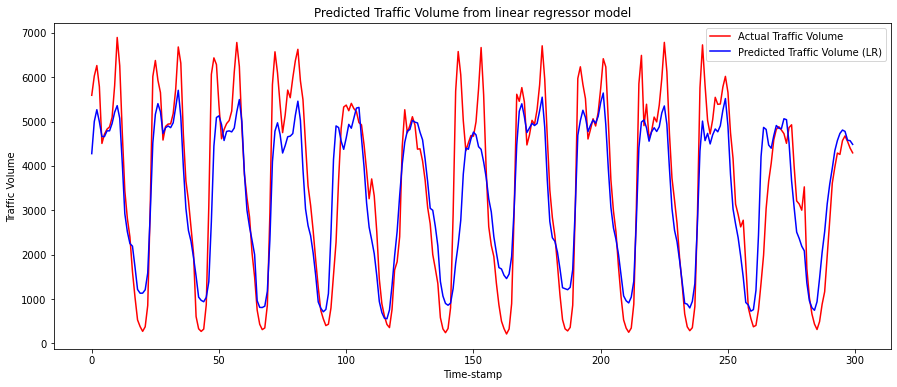

In [22]:
# slice data for plotting
Y_plot = Y_ts[0:300]
#slice prediction
ypred_plot_raw = y_predict[0:300]

# Plot both to a screen
f, ax = plt.subplots(figsize=(15,6))
ax.plot(Y_plot, label="Actual Traffic Volume", color='r')
ax.plot(ypred_plot_raw, label="Predicted Traffic Volume (LR)", color='b')
ax.set_title("Predicted Traffic Volume from linear regressor model")
ax.set_ylabel("Traffic Volume")
ax.set_xlabel('Time-stamp')
ax.legend()
None

It appears that on average the model is much more conservative in its estimates of traffic volumes 24h into the future than is actually the case

#### Stochastic Gradient Descent - checking to see if results from linear regression model can be replicated

Given the strange results from the linear regression analysis, it may be beneficial to check if the linear model was implemented correctly. Another method to do this is to use _stochastic gradient descent_ which is an __optimisation algorithm__ which alters __Beta__ coefficients at each iteration via sampling of random points to minimise the lost/cost/error function. Setting this loss function to __squared_error__ results is equivalent to an ordinary least squares algorithm.

In [23]:
# Run the SGD function
SGD = SGDRegressor(loss = "squared_error", 
                    max_iter=1000, 
                    tol=1e-3,
                    eta0 = 0.001, # decrease the learning rate (default 0.01), if too high model converges too quickly
                    random_state=332)
SGD.fit(X_tr_scaled, Y_tr)
y_predict = SGD.predict(X_ts_scaled)

print("TESTING SET METRICS")
print('Traffic Volume Test - R-squared: {:.5f}'.format(SGD.score(X_ts_scaled, Y_ts)))
print('Traffic Volume Test - MAE: {:.3f}'.format(mean_absolute_error(Y_ts, y_predict)))
print('Traffic Volume Training - MAPE: {:.2f}'.format(MAPE(Y_ts, y_predict)))

TESTING SET METRICS
Traffic Volume Test - R-squared: 0.73976
Traffic Volume Test - MAE: 757.011
Traffic Volume Training - MAPE: 0.60


#### Summary of SGD findings

- The MAE and R-squared values are slightly different for the SGD algorithm. This is due to the __random nature of the SGD algorithm__ by taking one point at random, computing the loss function and updating the coefficients to reduce the loss function. If we removed the `random_state` paramater, we would achieve different but highly similar MAE and R-squared results each time we run the model.
- The results are very similar to the Linear model above which suggests that the linear model was implemented correctly

### Model 2: Random Forest Regressor

- As discussed previously multi-variate linear models rely on the assumption of linear relationships between the independent and dependent variables. In real scenarios, this assumption does not hold and is where the non-linear regression algorithms come into picture that are able to __capture the non-linearity__ within the data.

In [24]:
# Set up a random forest model
model_rf = RandomForestRegressor(n_estimators= 5, # number of trees
                                 random_state=10, # seed for reproducibility
                                 bootstrap = True) # bootstrapping = true
# Fit to the data
model_rf.fit(X_tr_scaled, Y_tr)
rf_y_predict_train = model_rf.predict(X_tr_scaled) # predict the training set
rf_y_predict = model_rf.predict(X_ts_scaled) # predict the testing set

# Evaluation metrics
print("TRAINING SET METRICS - Random Forest")
print('Traffic Volume Test - R-squared: {:.5f}'.format(model_rf.score(X_tr_scaled, Y_tr)))
print('Traffic Volume Test - MAE: {:.3f}'.format(mean_absolute_error(Y_tr, rf_y_predict_train)))

print()

print("TESTING SET METRICS - Random Forest")
print('Traffic Volume Test - R-squared: {:.5f}'.format(model_rf.score(X_ts_scaled, Y_ts)))
print('Traffic Volume Test - MAE: {:.3f}'.format(mean_absolute_error(Y_ts, rf_y_predict)))
print('Traffic Volume Training - MAPE: {:.2f}'.format(MAPE(Y_ts, rf_y_predict)))

TRAINING SET METRICS - Random Forest
Traffic Volume Test - R-squared: 0.93630
Traffic Volume Test - MAE: 260.225

TESTING SET METRICS - Random Forest
Traffic Volume Test - R-squared: 0.88701
Traffic Volume Test - MAE: 403.616
Traffic Volume Training - MAPE: 0.23


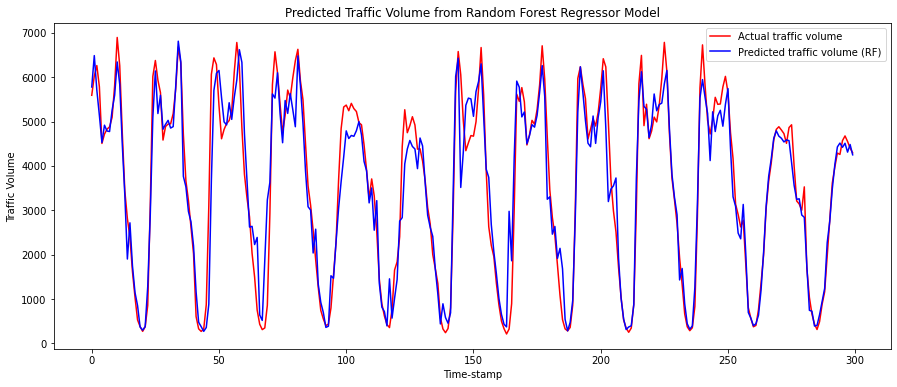

In [25]:
# Slice the data for plotting
Y_plot = Y_ts[0:300]
ypred_plot_raw = rf_y_predict[0:300]

# Plot both predicted and actual datasets
f, ax = plt.subplots(figsize=(15,6))
ax.plot(Y_plot, label="Actual traffic volume", color='r')
ax.plot(ypred_plot_raw, label="Predicted traffic volume (RF)", color='b')
ax.set_title("Predicted Traffic Volume from Random Forest Regressor Model")
ax.set_ylabel("Traffic Volume")
ax.set_xlabel('Time-stamp')
ax.legend()
None

- We can see that the `RandomForestRegressor` does a much better job at predicting a day in advance however, it appears that most of the deviation occurs at the weekend timestamps (when traffic volume is lower on average).
    - The R2 metric (0.93630 and 0.88701 in training and testing set)  and the MAE (260.225 and 403.616) values both refelect the good performance of the Random forest regressor as opposed to the linear model. The MAPE in the testing set is also very good at 0.23
- Given that the train accuracy is higher than the test accuracy, our random forest model is said to be __overfitting__ to the training data slightly

***

## Task 3

***


### 1.	Given that the linear numeric encoding of the hour, day and month features may miss cyclical signals, investigate and test a cyclical strategy for encoding these features. Does this strategy improve accuracy for the models tested in Task 2?

- Cyclical signals are a welll recognised problem in machine learning. There are cyclical signals in this data as can be seen from the periodoic plots generated above. The problem is that e.g. hour 23 and hour 0 are very similar to each other and there is a requirement to encode this information so that the system(sklearn) can __utilise this information correctly__.
    - In other words, we need to encode the cyclical features such that hour 0 and hour 23 are the same distance apart as e.g., hour 4 and 5 respectively in order mitigate against these __jump inconsistencies__. As our data is cyclical, we need to encode it as a _cycle_
- A common method for encoding cyclical data is to transform the data into two dimensions using a _sine and cosine transformation_.
- We must use the sine and cosines transformation as if we used only one method, __two different values would get the same value when cyclically encoded__, therefore, having the two systems circumvents this issue

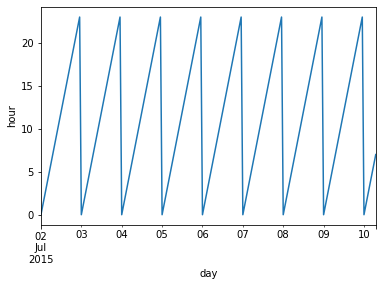

In [26]:
# viewing cyclic nature of hour
# Similar pattern holds for hour of day, day of month, and month, these all need to be cycically encoded
sample = traffic_volume_raw_2[0:200]
ax = sample["hour"].plot()
ax.set_ylabel("hour")
ax.set_xlabel('day')
None

#### Cyclical encoding
- Sine transformation ensures that the absolute differences before and after midnight (.e betwen 23, 0 and 0 + 1) are the same. However a problem occurs when two records possess the same sine values even though they themselves may be absolutely different from 0 hours
- The cosine transformation is utilised to separate the duplicated sine vlaue records from each other
- Plotting the cosine transformation and sine transformation on a 2D plot highlights that the data is encoded as a cycle - exactly what we want to show - e.g., day 6 is as close to day 0 and day 5 as day 3 is as close to day 4 and 2 respectively

- The formula for sine transformation is : $x_{sin}$ = sin((2*π*x))/max(x))

- The formula for the cosine transformation is $x_{cos}$ = cos((2*π*x))/max(x))

- We can use methods from the `numpy` module to conduct the sine/cosine transformation

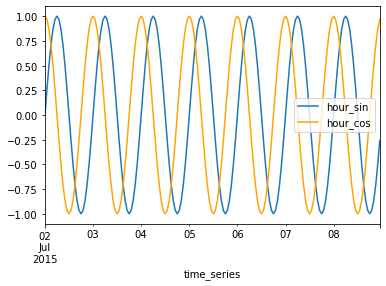

In [27]:
# Get the data again, edit it and split again
data_cyc = traffic_volume_raw_2

# Generate the varaible using the formula for sine transformation and cosine transformation
# Divide by 24 - number of hours in the day
data_cyc['hour_sin'] = np.sin(2 * np.pi * data_cyc['hour']/24) # perform the sin transformation
data_cyc['hour_cos'] = np.cos(2 * np.pi * data_cyc['hour']/24) # perform the cosine transformation

sample = data_cyc[0:168] # select a sample for plotting
ax = sample['hour_sin'].plot() # checking to see the sin and cosine transformation
ax = sample['hour_cos'].plot(color = "orange") # can see that it is encoded as a cycle from the transformations
ax.legend()
None

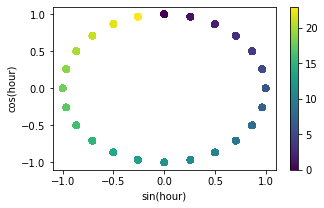

In [28]:
# Plotting both on a 2 D plot
# Can see that the hour variable is now encoded as a cycle
fig, ax = plt.subplots(figsize=(5, 3))
sp = ax.scatter(data_cyc["hour_sin"], data_cyc["hour_cos"], c=data_cyc["hour"])
ax.set(
    xlabel="sin(hour)",
    ylabel="cos(hour)",
)
_ = fig.colorbar(sp)

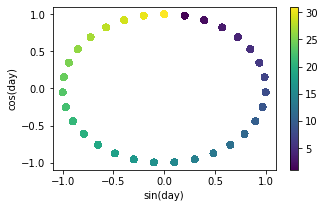

In [29]:
# Repeat for Day - note the 31 points for each day
data_cyc['day_sin'] = np.sin(2 * np.pi * data_cyc['day']/31) # perform the sin transformation
data_cyc['day_cos'] = np.cos(2 * np.pi * data_cyc['day']/31) # perform the cosine transformation

# Plot the data
fig, ax = plt.subplots(figsize=(5, 3))
sp = ax.scatter(data_cyc["day_sin"], data_cyc["day_cos"], c=data_cyc["day"])
ax.set(
    xlabel="sin(day)",
    ylabel="cos(day)",
)
_ = fig.colorbar(sp)

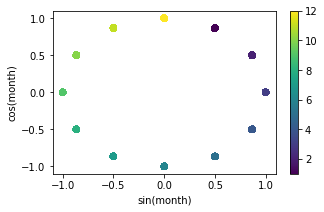

In [30]:
# Repeat for month, note the 12 for number of months
data_cyc['month_sin'] = np.sin(2 * np.pi * data_cyc['month']/12) # perform the sin transformation
data_cyc['month_cos'] = np.cos(2 * np.pi * data_cyc['month']/12) # perform the cosine transformation

# Plot the data
fig, ax = plt.subplots(figsize=(5, 3))
sp = ax.scatter(data_cyc["month_sin"], data_cyc["month_cos"], c=data_cyc["month"])
ax.set(
    xlabel="sin(month)",
    ylabel="cos(month)",
)
_ = fig.colorbar(sp)

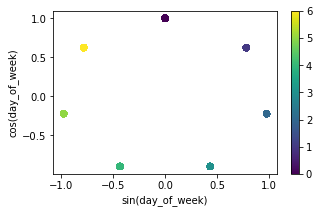

In [31]:
# Repeat for Day of week - note the 7 points for each day
data_cyc['day_week_sin'] = np.sin(2 * np.pi * data_cyc['day_of_week']/7) # perform the sin transformation
data_cyc['day_week_cos'] = np.cos(2 * np.pi * data_cyc['day_of_week']/7) # perform the cosine transformation
fig, ax = plt.subplots(figsize=(5, 3))
sp = ax.scatter(data_cyc["day_week_sin"], data_cyc["day_week_cos"], c=data_cyc["day_of_week"])
ax.set(
    xlabel="sin(day_of_week)",
    ylabel="cos(day_of_week)",
)
_ = fig.colorbar(sp)

#### Summary of cyclical encoding component
- Here, we have encoded the data to ensure that there are no __jump inconsistencies__ and that e.g., month 12 is as close to month 1 as month 3 is to month 4. We deployed this cyclical encoding strategy on the _hour, month, day_ and _day_of_week_ variables


#### Evaluating the cyclical encoding strategy on linear and randomforest regressors

In [32]:
# Same code as above

# ---------------------------------------------------------------------------------------------------------------------------
# --------------------------------------------------- Data Preprocessing ----------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------------

## Reorganising data
# Note original hour, month and day variables dropped
traffic_final = data_cyc[['rain_1h', "snow_1h", 'temp', 'clouds_all', 'hour_sin', 'hour_cos',
                          'day_sin', 'day_cos', 'month_sin', 'month_cos', 'day_week_sin', 'day_week_cos', 't-23','t-22','t-21','t-20',
                          't-19','t-18','t-17','t-16','t-15','t-14','t-13','t-12','t-11','t-10','t-9',
                          't-8','t-7','t-6','t-5','t-4','t-3', 't-2','t-1',
                          'traffic_volume','t+24']]

# Extracting independent and dependent variables
# These are columns with a + in them i.e., into the future from the time stamp
# Define the target columns
Y = traffic_final.pop("t+24").values
X = traffic_final.values

# Splitting
X_tr, X_ts, Y_tr, Y_ts = train_test_split(X, Y, test_size=1/3, shuffle=False) # shuffle = false as it is time series data


# Scaling the features of the data
scaler = StandardScaler()
X_tr_scaled = scaler.fit_transform(X_tr) # fit and transform the training data 
X_ts_scaled = scaler.transform(X_ts) # transform the test data set

# ---------------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------- Linear Regression ----------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------------
# set up the model
# Fit to the train and predict in the test
linear = LinearRegression()
linear.fit(X_tr_scaled, Y_tr)
y_predict_train = linear.predict(X_tr_scaled)
y_predict = linear.predict(X_ts_scaled)

# Evaluate peroformance
print("TRAINING SET METRICS - Linear Regression")
print('Traffic Volume Test - R-squared: {:.5f}'.format(linear.score(X_tr_scaled, Y_tr)))
print('Traffic Volume Test - MAE: {:.3f}'.format(mean_absolute_error(Y_tr, y_predict_train)))

print()

print("TESTING SET METRICS - Linear Regression")
print('Traffic Volume Test - R-squared: {:.5f}'.format(linear.score(X_ts_scaled, Y_ts)))
print('Traffic Volume Test - MAE: {:.3f}'.format(mean_absolute_error(Y_ts, y_predict)))
print('Traffic Volume Training - MAPE: {:.2f}'.format(MAPE(Y_ts, y_predict)))
print()
# ---------------------------------------------------------------------------------------------------------------------------
# ------------------------------------------------------- Random Forest  ----------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------------

# Set up the model as above
model_rf = RandomForestRegressor(n_estimators= 5, random_state=10, bootstrap = True)
# fit to the trianing data
model_rf.fit(X_tr_scaled, Y_tr) 

# Predict in both test and train
# Evaluate performance
rf_y_predict_train = model_rf.predict(X_tr_scaled)
rf_y_predict = model_rf.predict(X_ts_scaled)
print("TRAINING SET METRICS - Random Forest")
print('Traffic Volume Test - R-squared: {:.5f}'.format(model_rf.score(X_tr_scaled, Y_tr)))
print('Traffic Volume Test - MAE: {:.3f}'.format(mean_absolute_error(Y_tr, rf_y_predict_train)))

print()

print("TESTING SET METRICS - Random Forest")
print('Traffic Volume Test - R-squared: {:.5f}'.format(model_rf.score(X_ts_scaled, Y_ts)))
print('Traffic Volume Test - MAE: {:.3f}'.format(mean_absolute_error(Y_ts, rf_y_predict)))
print('Traffic Volume Training - MAPE: {:.2f}'.format(MAPE(Y_ts, rf_y_predict)))

TRAINING SET METRICS - Linear Regression
Traffic Volume Test - R-squared: 0.53148
Traffic Volume Test - MAE: 957.631

TESTING SET METRICS - Linear Regression
Traffic Volume Test - R-squared: 0.76191
Traffic Volume Test - MAE: 719.886
Traffic Volume Training - MAPE: 0.57

TRAINING SET METRICS - Random Forest
Traffic Volume Test - R-squared: 0.93720
Traffic Volume Test - MAE: 258.818

TESTING SET METRICS - Random Forest
Traffic Volume Test - R-squared: 0.88240
Traffic Volume Test - MAE: 416.966
Traffic Volume Training - MAPE: 0.25


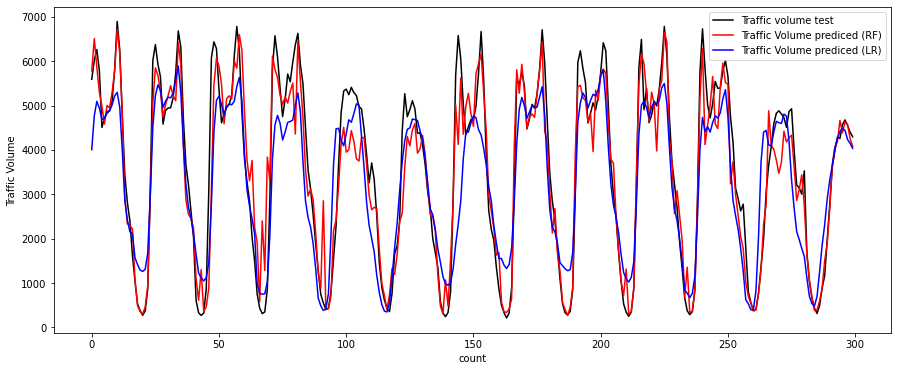

In [33]:
# Slice data for plotting from both linear regression and Random forest
Y_plot = Y_ts[0:300]
ypred_plot_LR = y_predict[0:300]
ypred_plot_RF = rf_y_predict[0:300]

# Plot all 3 values and compare
f, ax = plt.subplots(figsize=(15,6))
ax.plot(Y_plot, label="Traffic volume test", color='black')
ax.plot(ypred_plot_RF, label="Traffic Volume prediced (RF)", color='r')
ax.plot(ypred_plot_LR, label="Traffic Volume prediced (LR)", color='b')
ax.set_ylabel("Traffic Volume")
ax.set_xlabel('count')
ax.legend()
None

### Evaluation of the cyclical encoding strategy on both models

- For the __linear regression model__, the cyclical encoding strategy __improved the coefficient of determination value and decreased the MAE in the train and test sets__. In the test set, the MAPE was also reduced indicating an improvement to the model's predictive power. However, the linear model has still performed extremly poorly with a lower accuracy in the train set then the test set suggesting that the model appear to be only performing well in the test set due to random chance. Ideally, the train and test set accuracies should be close to each other for the deployment of a reliable model.


- For the Random Forest regressor, the __accuracy actually decreased__, but only slightly in both the training and testing sets. _A reason for this might be due to the fact decision tree based algorithms such as Random Forest build their split rules one feature at a time __ignoring the relationship between sin/cos values__ which is the whole point of the sin/cosine transformations_ 
    - __Feature Selection__ (below) may improve the model's performance and generalizability. Overall, however, the predictive performance of the Random Forest model is very good on both the train and test datasets


- The plot above, showing the predicted values and actual values in the test set clearly illustrates that the RF model outperforms the LR model however the RF model appears to be quite poor during the weekend days when traffic volume is lower on average.


- Again, with the Random Forest Regressor, overfitting remains a problem in this data set due to the poorer performance

***
## Task 4
***


### 1. Identify subsets of the features for this prediction task. These can be the same subset for all models or model-specific subsets

- Feature subset selection involves finding those features which accuractly describe the phenomenen (traffic volume a day in advance) and discarding those which do not to ultimately;
    - Build better predictor/model (no curse of dimensionality)
    - Knowledge discovery
    - Reduced cost if some variables are expensive to measure
    - Make the model more interpretable

- We will look at feature selection in the __training set__ then once a number of features are selected, we will __evaluate in the test set__. Of important note is to __keep the testing set totally independent of the feature selection process__

### Linear Regression features
- Although the linear regressor appears to be a poor model for this time series prediction analysis, _investigating the variables included in this model may be lucractive in terms of identifying which variables are important._

#### Beta coefficents
- Given that we all variables are standardised, we can __look at the beta values__ to determine which variables are having a large effect in the model at predicting traffic volume a day in advance, this can give us an insight into which variables are important
    - The `linear.coef_` function illustrates the Beta values for a given model

In [34]:
# Set up feature names variable for all variables trained
feature_names = ('rain_1h', 'snow_1h', 'temp', 'clouds_all', 'hour_sin', 'hour_cos','day_sin', 'day_cos', 'month_sin', 
                 'month_cos', 'day_week_sin','day_week_cos', 't-23', 't-22', 't-21', 't-20', 't-19', 't-18', 't-17',
                 't-16', 't-15', 't-14', 't-13', 't-12', 't-11', 't-10', 't-9', 't-8',
                 't-7', 't-6', 't-5', 't-4', 't-3', 't-2', 't-1', 'traffic_volume')

# Convert coefficients to dataframe and match wit the feature names vector == order of X_tr_scaled object
# Sort and print to the screen
linear_beta_df = pd.DataFrame(linear.coef_, index=feature_names,columns =['Beta'])
linear_beta_df.sort_values(by='Beta',inplace=True, ascending = False)
linear_beta_df

,Beta
traffic_volume,743.861324
day_week_sin,234.335123
t-23,213.325601
day_week_cos,178.101470
t-1,141.770038
hour_sin,60.818913
month_sin,38.238239
t-19,31.902950
t-2,23.391339
t-16,17.099957


- Can see here that the __current traffic volume time stamp__ is having the largest effect in the model, followed by __day_week_sin__ and __t-23__. The next variable is __hour_cos__ which appears to be having a negative impact on traffic_volume predictions. Variables which do not appear to be having a large effect on the model include temp, rain_1h, clouds and snow

__Sequential Forward selection__

- Wrapper methods for feature selection are useful as they take bias of specific learning algorims into account and consider feature dependancies. There are a number of feature selection strategies however we will focus on __Sequential search strategies__ ; 1, Forward and 2, Backward. These are fast search algorithms based on a greedy algorithm which subset features by adding or removing one feature at a time.

C:\Users\crtuser\anaconda3\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\crtuser\anaconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


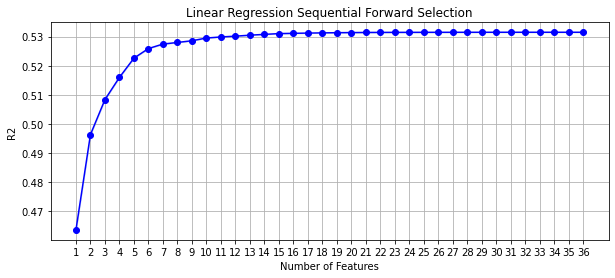

Best number of features: 36 and R2 value: 0.53148
Features: ('rain_1h', 'snow_1h', 'temp', 'clouds_all', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'day_week_sin', 'day_week_cos', 't-23', 't-22', 't-21', 't-20', 't-19', 't-18', 't-17', 't-16', 't-15', 't-14', 't-13', 't-12', 't-11', 't-10', 't-9', 't-8', 't-7', 't-6', 't-5', 't-4', 't-3', 't-2', 't-1', 'traffic_volume')

Top 10 feature groups and R2 value
Features for group 1:('traffic_volume',)R2 value:0.46366
Features for group 2:('t-12', 'traffic_volume')R2 value:0.49636
Features for group 3:('day_week_cos', 't-12', 'traffic_volume')R2 value:0.50837
Features for group 4:('day_week_sin', 'day_week_cos', 't-12', 'traffic_volume')R2 value:0.51599
Features for group 5:('hour_cos', 'day_week_sin', 'day_week_cos', 't-12', 'traffic_volume')R2 value:0.52259
Features for group 6:('hour_cos', 'day_week_sin', 'day_week_cos', 't-23', 't-12', 'traffic_volume')R2 value:0.52589
Features for group 7:('hour_cos', 'day_we

In [35]:
# Need to convert X_tr_scaled back to pandas dataframe in order to display the column names to determine feature importance

# The "custom_feature_names" has been removed from mlxtend
X_tr_scaled_df = pd.DataFrame(X_tr_scaled, columns=feature_names)

# Initialise feature number
k = int(X.shape[1])

# Feed forward feature Selection
sfs = SFS(linear,        # Our model
          k_features=k,  # Number of features to *Go up to*
          forward=True,  # Specifying that it is forward
          floating=False, 
          scoring='r2', # Our evaluation metric
          cv=0, # using training set for evaluation
         n_jobs=-1) # Use all available cores

# Fit to the training data
# Plot
sfs = sfs.fit(X_tr_scaled_df, Y_tr)
fig = plot_sfs(sfs.get_metric_dict(), ylabel="R2", figsize=(10, 4))
plt.title('Linear Regression Sequential Forward Selection')
plt.grid()
plt.show()

# Extracting results
lm_acc = list() # set up a list
for i in range(36,0, -1): # cycle through all results
    acc = float(sfs.subsets_[i]["avg_score"]) # get accuracy
    lm_acc.append(acc) # append to list
max_value = max(lm_acc)  # get best value
max_index = 36 - int(lm_acc.index(max_value)) # get index for this value

# Use index to print best feature group and R2 value
print(f'Best number of features: {len(sfs.subsets_[max_index]["feature_names"])} and R2 value: {round(sfs.subsets_[max_index]["avg_score"],5)}')
print(f'Features: {str(sfs.subsets_[max_index]["feature_names"])}')
print()

# Looking at important feature groups
print(f'Top 10 feature groups and R2 value')
for i in range(1,11):
    print(f'Features for group {i}:{str(sfs.subsets_[i]["feature_names"])}R2 value:{round(sfs.subsets_[i]["avg_score"],5)}')
    

- __Backward selection__
    - Forward sequential search is extremely fast. However, backward sequential search, essentially the opposite of forward sequential search tends to produce better models as it considers feature dependencies at the cost of increased running time

C:\Users\crtuser\anaconda3\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\crtuser\anaconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


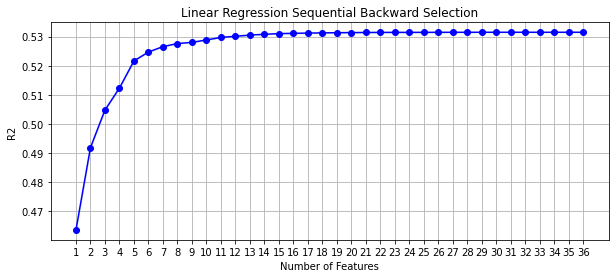

Best number of features: 36 and R2 value: 0.53148
Features: ('rain_1h', 'snow_1h', 'temp', 'clouds_all', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'day_week_sin', 'day_week_cos', 't-23', 't-22', 't-21', 't-20', 't-19', 't-18', 't-17', 't-16', 't-15', 't-14', 't-13', 't-12', 't-11', 't-10', 't-9', 't-8', 't-7', 't-6', 't-5', 't-4', 't-3', 't-2', 't-1', 'traffic_volume')

Top 10 feature groups and R2 value
Features for group 1:('traffic_volume',) R2:0.46366
Features for group 2:('t-13', 'traffic_volume') R2:0.49189
Features for group 3:('day_week_cos', 't-13', 'traffic_volume') R2:0.50478
Features for group 4:('hour_cos', 'day_week_cos', 't-13', 'traffic_volume') R2:0.51234
Features for group 5:('hour_cos', 'day_week_sin', 'day_week_cos', 't-13', 'traffic_volume') R2:0.52164
Features for group 6:('hour_cos', 'day_week_sin', 'day_week_cos', 't-23', 't-13', 'traffic_volume') R2:0.52469
Features for group 7:('hour_cos', 'day_week_sin', 'day_week_cos', 't-23', '

In [36]:
# Set up backward selection object
sbs = SFS(linear,  # our model
          k_features=1,  # number of features *to go down to*
          forward=False, # Setting to the reverse of default which is feed forward
          floating=False, 
          scoring='r2',
          cv=0,
         n_jobs=-1) # using training set for evaluation - CV not appropriate

# Evaluate on the training data
sbs = sbs.fit(X_tr_scaled_df, Y_tr)

# Plot the output
fig = plot_sfs(sbs.get_metric_dict(), ylabel="R2", figsize=(10, 4))
plt.title('Linear Regression Sequential Backward Selection')
plt.grid()
plt.show()

lm_acc = list()
for i in range(36,0, -1):
    acc = float(sbs.subsets_[i]["avg_score"])
    lm_acc.append(acc)
max_value = max(lm_acc) 
max_index = 36 - int(lm_acc.index(max_value))
print(f'Best number of features: {len(sbs.subsets_[max_index]["feature_names"])} and R2 value: {round(sbs.subsets_[max_index]["avg_score"],5)}')
print(f'Features: {str(sbs.subsets_[max_index]["feature_names"])}')
print()
print(f'Top 10 feature groups and R2 value')
for i in range(1,11):
    print(f'Features for group {i}:{str(sbs.subsets_[i]["feature_names"])} R2:{round(sbs.subsets_[i]["avg_score"],5)}')

### Summary of Wrapper methods for linear Regression model
Both methods have suggested that __traffic_volume is the most important feature__. When we look at the top 5 features out of all possible 35, 8 are common (traffic_volume, t-1, t-17, t-7, t-23, day_week_cos, day_week_sin, hour_cos).  Adding additional features after the top 10 features yields little improvement in the coefficient of determination scoring value. The fact that _temp_ or _snow_ or _clouds_all_ have not appeard in the top 10 suggeest that they are __not important in predicting traffic volume a day in advance__

### Random Forest feature selection and final model evalutaton
- Given that Random Forest is the best performing model for this data type, primarily due to its ability to exploit non-linear relationships, we will;
    - Evaluate the importance of each feature in the Random Forest Model
    - Combine our knowledge with findings thus far from the linear regression feature importance analysis 
    - Subset features
    - Perform grid search to determine hyperparamaters
    - Evaluate one last time in the test dataset
    
#### Random Forest feature importance

Random Forest is able to provide an estimate of feature importance with the `feature.importances_` attribute

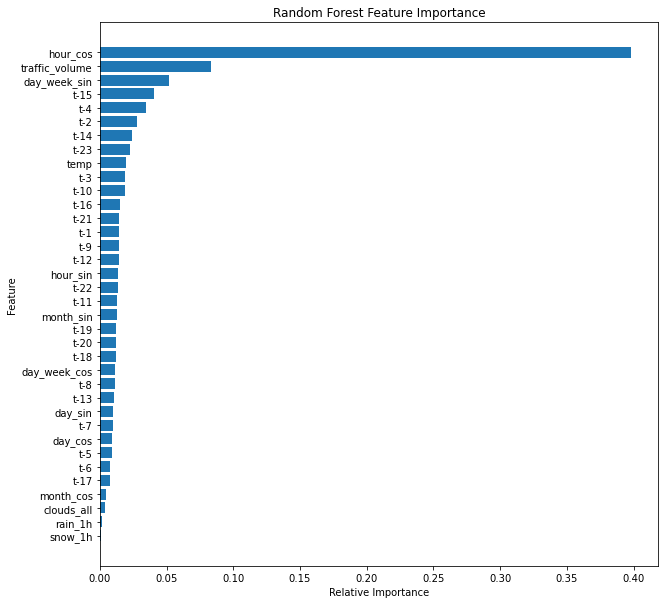

In [37]:
# Obtain the feature importance score from the feature_imporances_ attribute
# Convert to a data frame, Sort the data frame and plot as a horizontal barchart
FI_df = pd.DataFrame(model_rf.feature_importances_, index=feature_names,columns =['FI Score'])
FI_df_sorted = FI_df.sort_values(by='FI Score',inplace=False, ascending = True)
# Plotting code
f, ax = plt.subplots(figsize=(10,10))
ax.barh(FI_df_sorted.index, FI_df_sorted["FI Score"])
ax.set_title("Random Forest Feature Importance")
ax.set_ylabel("Feature")
ax.set_xlabel('Relative Importance')
None

### Random Forest feature permutation importance

- This `permutation_importance` function will randomly shuffle each feature `n_repeats` times and compute the change in the Random Forest model's performance. The features which impact the performance the most are the most important one. The permutation metric is defined to be the difference between the baseline metric and metric from permutating the feature column: https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html#sklearn.inspection.permutation_importance.

- These results of this analysis __should be taken with caution__ as because we have a lot of features, the impact of each feature is minimised and hence this method may not be the most suitable

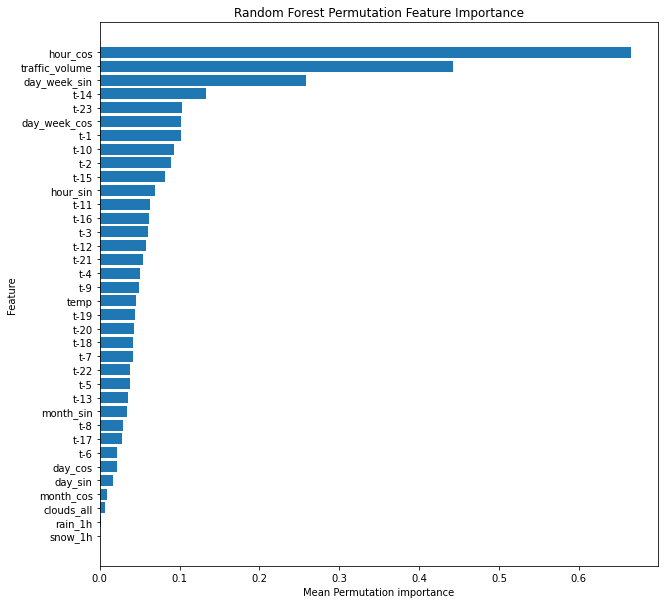

In [38]:
#Obtain values of permutation importance using the permutation_importance_function
perm_importance = permutation_importance(model_rf, # model 
                                         X_tr_scaled, # training data 
                                         Y_tr, # training data y 
                                         scoring="r2", #score based on R2 
                                         random_state=10, # setting seed for reproducibility 
                                         n_repeats=5) # number of times a feature is shuffled

# Convert to a data frame, sort and plot as a horizontal barchart similar to above
RF_perm_df = pd.DataFrame(perm_importance.importances_mean, index=feature_names, columns =['Mean_Permutation'])
RF_perm_df_sorted = RF_perm_df.sort_values(by="Mean_Permutation",inplace=False, )
f, ax = plt.subplots(figsize=(10,10))
ax.barh(RF_perm_df_sorted.index, RF_perm_df_sorted["Mean_Permutation"])
ax.set_title("Random Forest Permutation Feature Importance")
ax.set_ylabel("Feature")
ax.set_xlabel('Mean Permutation importance')
None

It appears that both methods suggest that hour_cos, current traffic_volume and day_week_sin are important variables in predicting traffic volume a day in advance. It appears that rain_1h and snow_1h are not important at all in predicting traffic volume

### Random Forest Forward/Backward Sequential Searches
- Although it will take a while to run and is computationally expensive, it will be beneficial to utilise the forward/backward sequential search to identify important features within the Random Forest Regressor

C:\Users\crtuser\anaconda3\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\crtuser\anaconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


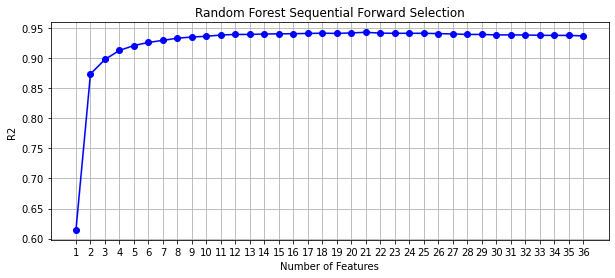

Best number of features: 21 and R2 value: 0.94325
Features: ('snow_1h', 'temp', 'clouds_all', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'day_week_sin', 'day_week_cos', 't-23', 't-22', 't-21', 't-20', 't-19', 't-18', 't-13', 't-10', 't-2', 'traffic_volume')

Top 10 feature groups and R2 value
Features for group 1:('traffic_volume',)R2 value:0.61439
Features for group 2:('t-23', 'traffic_volume')R2 value:0.87396
Features for group 3:('t-23', 't-2', 'traffic_volume')R2 value:0.89803
Features for group 4:('day_week_sin', 't-23', 't-2', 'traffic_volume')R2 value:0.91309
Features for group 5:('day_week_sin', 't-23', 't-10', 't-2', 'traffic_volume')R2 value:0.92117
Features for group 6:('hour_cos', 'day_week_sin', 't-23', 't-10', 't-2', 'traffic_volume')R2 value:0.92637
Features for group 7:('hour_cos', 'day_week_sin', 't-23', 't-21', 't-10', 't-2', 'traffic_volume')R2 value:0.92975
Features for group 8:('hour_cos', 'month_cos', 'day_week_sin', 't-23', 't-21', 't

In [39]:
# Need to convert X_tr_scaled back to pandas dataframe in order to display the column names to determine feature importance
# The "custom_feature_names" has been removed from mlxtend
X_tr_scaled_df = pd.DataFrame(X_tr_scaled, columns=feature_names)

# Initialise feature number
k = int(X.shape[1])

# Feed forward feature Selection
sfs = SFS(model_rf,        # Our model
          k_features=k,  # Number of features to *Go up to
          forward=True,  # Specifying that it is forward
          floating=False, 
          scoring='r2', # Our evaluation metric
          cv=0,
         n_jobs=-1) # using training set for evaluation

# Fit function to the data
# Plot results
sfs = sfs.fit(X_tr_scaled_df, Y_tr)
fig = plot_sfs(sfs.get_metric_dict(), ylabel="R2", figsize=(10, 4))
plt.title('Random Forest Sequential Forward Selection')
plt.grid()
plt.show()

# Get the max results
sfs_acc = list() # set up a list
for i in range(36,0, -1): # cycle through all results
    acc = float(sfs.subsets_[i]["avg_score"]) # get the accuracy
    sfs_acc.append(acc) # append to a list
max_value = max(sfs_acc) # get max index
max_index = 36 - int(sfs_acc.index(max_value)) # Get the index 
# Print results to the screen
print(f'Best number of features: {len(sfs.subsets_[max_index]["feature_names"])} and R2 value: {round(sfs.subsets_[max_index]["avg_score"],5)}')
print(f'Features: {str(sfs.subsets_[max_index]["feature_names"])}')
print()
# Looking at important feature groups
print(f'Top 10 feature groups and R2 value')
for i in range(1,11):
    print(f'Features for group {i}:{str(sfs.subsets_[i]["feature_names"])}R2 value:{round(sfs.subsets_[i]["avg_score"],5)}')
    

C:\Users\crtuser\anaconda3\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\crtuser\anaconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


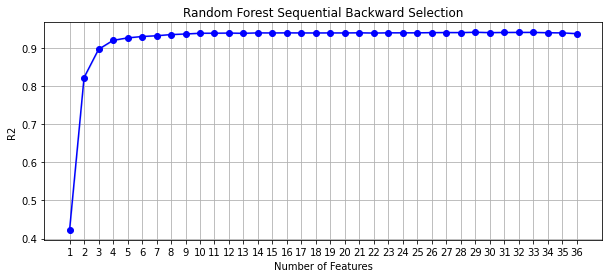

Best number of features: 29 and R2 value: 0.94085
Features: ('rain_1h', 'snow_1h', 'temp', 'clouds_all', 'hour_cos', 'day_cos', 'month_sin', 'month_cos', 'day_week_sin', 'day_week_cos', 't-23', 't-21', 't-20', 't-18', 't-16', 't-15', 't-14', 't-13', 't-11', 't-10', 't-8', 't-7', 't-6', 't-5', 't-4', 't-3', 't-2', 't-1', 'traffic_volume')

Top 10 feature groups and R2 value
Features for group 1:('t-4',) R2:0.42281
Features for group 2:('t-15', 't-4') R2:0.82217
Features for group 3:('hour_cos', 't-15', 't-4') R2:0.89603
Features for group 4:('hour_cos', 'day_week_sin', 't-15', 't-4') R2:0.9196
Features for group 5:('hour_cos', 'day_week_sin', 't-20', 't-15', 't-4') R2:0.92607
Features for group 6:('hour_cos', 'month_cos', 'day_week_sin', 't-20', 't-15', 't-4') R2:0.92965
Features for group 7:('hour_cos', 'day_cos', 'month_cos', 'day_week_sin', 't-20', 't-15', 't-4') R2:0.93168
Features for group 8:('hour_cos', 'day_cos', 'month_sin', 'month_cos', 'day_week_sin', 't-20', 't-15', 't-4') R

In [40]:
# Set up backward selection object
sbs = SFS(model_rf,  # our model
          k_features=1,  # number of features *to go down to*
          forward=False, # Setting to the reverse of default which is feed forward
          floating=False, 
          scoring='r2',
          cv=0, # using training set for evaluation - CV not appropriate
         n_jobs=-1) # Use all available cores

# Evaluate on the training data
sbs = sbs.fit(X_tr_scaled_df, Y_tr)

# Plot the output
fig = plot_sfs(sbs.get_metric_dict(), ylabel="R2", figsize=(10, 4))
plt.title('Random Forest Sequential Backward Selection')
plt.grid()
plt.show()

# Again, get the best feature group and best accuracy
sbs_acc = list() # set up a list
for i in range(36,0, -1):  # cycle through all results
    acc = float(sbs.subsets_[i]["avg_score"]) # get the accuracy
    sbs_acc.append(acc) # append to a list
max_value = max(sbs_acc) # get max index
max_index = 36 - int(sbs_acc.index(max_value)) # Get the index 
# Print results to the screen
print(f'Best number of features: {len(sbs.subsets_[max_index]["feature_names"])} and R2 value: {round(sbs.subsets_[max_index]["avg_score"],5)}')
print(f'Features: {str(sbs.subsets_[max_index]["feature_names"])}')
print()

# Looking at important feature groups
print(f'Top 10 feature groups and R2 value')
for i in range(1,11):
    print(f'Features for group {i}:{str(sbs.subsets_[i]["feature_names"])} R2:{round(sbs.subsets_[i]["avg_score"],5)}')

### Summary of wrapper methods and final feature selection

- For the forward sequential search, the best number of features was 21 with an accuracy (R2) of 0.94325. For the backward sequential search, the best number of features was 29 with an accuracy (R2) of 0.94085. These results suggest that better models can be achieved on the training set by including less features. Complex models do not always yield higher acccuracies.

- To identify a final subset of features for the prediction task, we combined information accross all 4 types of analyses (`feature_importances`, `permutation_importance` and both `SFS` methods). We looked for commonalities accross the best performing forward search group, best performing backward search group and the top 29 (size of the backward search group) features from the `feature_importances` and `permutation_importance` analyses. 

- Accross all these analyses the features: __traffic_volume, hour_cos, day_week_sin, month_sin, temp, day_week_cos, t-23, t-21, t-20, t-18,t-13, t-10, t-2__ (13 features) were common 

In [41]:
# subsetting important features common 
traffic_valid = data_cyc[["t+24", "traffic_volume", "hour_cos", "day_week_sin", "month_sin", "temp", "day_week_cos", "t-23", "t-21", "t-20", "t-18","t-13", "t-10", "t-2"]]
Y = traffic_valid.pop("t+24").values
X = traffic_valid.values
X_tr, X_ts, Y_tr, Y_ts = train_test_split(X, Y, test_size=1/3, shuffle=False) # shuffle = false as it is time series data
# Scaling the features of the data
scaler = StandardScaler()
X_tr_scaled = scaler.fit_transform(X_tr) # fit and transform the training data 
X_ts_scaled = scaler.transform(X_ts) # transform the test data set

### Random Forest Hyper-paramater Tuning
- Now that we have selected the features for the Random Forest Regressor, we will tune the hyper-paramaters to give the best model which we will first evaluate in the training set and then in the test set. Note, the test set whould not be used in evaluating hyperparamaters. This would invalidate the independence of the test dataset 

In [42]:
best_score = 0
best_parameters = dict()
# set paramaters we want to search through

for estimator in [1,2,5,10,20,50,100,500, 1000]: # number of trees
    for mf in ["sqrt", "log2", None]: # max features
        # for each combination of parameters, train an SVC
        RF = RandomForestRegressor(n_estimators=estimator, max_features=mf, bootstrap=True,random_state=10, n_jobs=-1) 
        RF.fit(X_tr_scaled, Y_tr)
        # evaluate the SVC on the test set
        score = RF.score(X_tr_scaled, Y_tr)
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'n_estimators': estimator , 'max_features': mf}
            print("Best score: {:.5f}".format(best_score))
            print("Best parameters: {}".format(best_parameters))

Best score: 0.80124
Best parameters: {'n_estimators': 1, 'max_features': 'sqrt'}
Best score: 0.82171
Best parameters: {'n_estimators': 1, 'max_features': None}
Best score: 0.88561
Best parameters: {'n_estimators': 2, 'max_features': 'sqrt'}
Best score: 0.89165
Best parameters: {'n_estimators': 2, 'max_features': None}
Best score: 0.93525
Best parameters: {'n_estimators': 5, 'max_features': 'sqrt'}
Best score: 0.93670
Best parameters: {'n_estimators': 5, 'max_features': None}
Best score: 0.95110
Best parameters: {'n_estimators': 10, 'max_features': 'sqrt'}
Best score: 0.95125
Best parameters: {'n_estimators': 10, 'max_features': None}
Best score: 0.95933
Best parameters: {'n_estimators': 20, 'max_features': 'sqrt'}
Best score: 0.96428
Best parameters: {'n_estimators': 50, 'max_features': 'sqrt'}
Best score: 0.96593
Best parameters: {'n_estimators': 100, 'max_features': 'sqrt'}
Best score: 0.96722
Best parameters: {'n_estimators': 500, 'max_features': 'sqrt'}
Best score: 0.96747
Best par

Accuracy increases as the number of trees increases. The number of max features also appears to be playing a role. Given that overfitting is a problem with a dense number of trees, __we will select a smaller set of 50 trees for the analysis on the test data.__

TESTING SET METRICS - Random Forest
Traffic Volume Test - R-squared: 0.91
Traffic Volume Test - MAE: 416.966
Traffic Volume Training - MAPE: 0.25


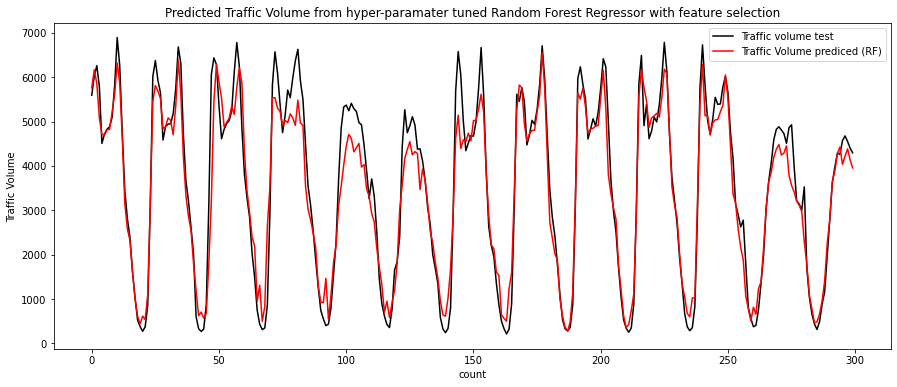

In [43]:
# Final evaluation
RF = RandomForestRegressor(n_estimators = 50, max_features = "sqrt", bootstrap=True, random_state=10, n_jobs=-1)
RF.fit(X_tr_scaled, Y_tr)
y_pred_valid = RF.predict(X_ts_scaled)
print("TESTING SET METRICS - Random Forest")
print('Traffic Volume Test - R-squared: {:.2f}'.format(RF.score(X_ts_scaled, Y_ts)))
print('Traffic Volume Test - MAE: {:.3f}'.format(mean_absolute_error(Y_ts, rf_y_predict)))
print('Traffic Volume Training - MAPE: {:.2f}'.format(MAPE(Y_ts, rf_y_predict)))


Y_plot = Y_ts[0:300]
ypred_plot_RF = y_pred_valid[0:300]
f, ax = plt.subplots(figsize=(15,6))
ax.plot(Y_plot, label="Traffic volume test", color='black')
ax.plot(ypred_plot_RF, label="Traffic Volume prediced (RF)", color='r')
ax.set_title("Predicted Traffic Volume from hyper-paramater tuned Random Forest Regressor with feature selection")
ax.set_ylabel("Traffic Volume")
ax.set_ylabel("Traffic Volume")
ax.set_xlabel('count')
ax.legend()
None

Here, the combination of feature selection and hyperparamater tuning has produced a better model than in task 2 and 3 respectively. The overall accuracy (R2) on the training dataset was 0.96428, better than the accuracy achieved in task 2 (0.93720). This is probably due to the inclusion of more trees in the model. When we compare the `n_estimators` paramater to the value employed in task 2 (i.e., 5), there is very little change in the model accuracy however the number of features included in this model has decreased by 63% (36 down to 13). The accuracy on the test set is also very good at 0.91 which indicates that __slight overfitting__ has taken place. Nonetheless, here we have identified a subset of features and a number of paramaters which produce a good RandomForestRegressor for predicting traffic_volume a day in advance.

The plot shows good concordance between the true and predicted values but it appears most of the deviation occurs at the weekend.

## Conclusion

- In __Task 1__ 
    - We loaded in the data into a format which could be used to predict traffic volume a day in advance. We removed duplicate entries and checked to make sure no data needed to be imputed.
    - We produced plots and noted that there was periodicity in traffic volume at the day and hour levels but not necessarily at the month level.
    
- In __Task 2__
    - We split the data into a train test set, employing a hold-out testing strategy and by setting the `shuffle` paramater to False.
    - We generated a linear `LinearRegression` model and a non-linear `RandomForestRegressor` model. We noted that the results were extremely poor for the linear model, especially in the training sets. We checked that the model was implemented correctly by using a `SGDRegressor` algorithm. We evaluated the models using a combination of the coefficient of determination, mean absolute error and mean absolute percentage error
    - The results were much better for the `RandomForestRegressor` however the model performed better in the training set than the testing set which suggests overfitting.

- In __Task 3__
    - We employed the __sin and cosine__ transformation to cyclically encode the hour, day of week, day of month and month variables. We observed that the accuracy of the linear regressor improved. The accuracy did not improve in the `RandomForestRegressor` which may be due to algorithm not considering sine/cosine variables simultaneously.

- In __Task 4__
    - We identified important features for the prediction of traffic volume a day in advance by looking at the the Beta-coeffiencts and wrapper based forward and backward sequential search methods in the Linear Regression model. Key features include current traffic_volume, t-1, t-17, t-7, t-23, day_week_cos, day_week_sin and hour_cos.
    - We repeated the search for important features from the Random Forest regressor. We used the `feature.importances_` attribute, and `permutation_importance` functions to identify key variables. We also employed wrapper based forward/backward sequential search algorithms. Different methods yielded different results. We selected a subset of 13 featues which showed evidence of being important accross all 4 analyses, these were traffic_volume, hour_cos, day_week_sin, month_sin, temp, day_week_cos, t-23, t-21, t-20, t-18,t-13, t-10, t-2.
    - Using these selected features, we performed a grid search of relevant paramaters to identify the best combination which predict traffic volume a day in advance. We selected a relatively small number of trees (from the `n_estimators` flag from the Random forest regressor and evaluated its performance on the test dataset. The overall accuracy of the model was good (0.91) however, this result indicates that slight overfitting has occurred.
 
- To conclude, we have performed model and feature selection in addition to feature engineering and hyperparamater tuning to create a RandomForest Model which is capable of predicting traffic volume a day in advance with reasonable accuracy (R2: 0.91). Another method which could extend from this project would be to evaluate other forms of models, e.g., support vector machines to see if they perform better than the RandomForestModel here. Another extension could be to perform horizon forecasting to predict traffic volume at 23h, 22h, 21h, 20h etc into the future. 